In [1]:
import torch, torchdata, torchtext
import torch.nn as nn

In [2]:
torch.__version__, torchdata.__version__, torchtext.__version__

('2.1.2', '0.7.1', '0.16.2')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# torch.cuda.get_device_name(0)

In [5]:
SEED = 1234 #change three times
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## 1. ETL: Loading the dataset

In [6]:
from torchtext.datasets import AG_NEWS

train, test = AG_NEWS() #classifying 4 types of news into World, Sports, Business, Tech

In [7]:
train #data pipe dataset - very similar to pytorch tensor dataset, but just more efficient

ShardingFilterIterDataPipe

## 2. EDA - simple investigation

In [8]:
next(iter(train))

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [9]:
set([y for y, x in list(iter(train))])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


{1, 2, 3, 4}

In [10]:
train_size = len(list(iter(train)))

In [11]:
train_size

120000

In [12]:
_, train, valid = train.random_split(total_length=train_size, 
                                     weights = {"too_much": 0.95, "train": 0.03, "val": 0.02},
                                     seed = SEED)

In [13]:
print(len(list(iter(train))))
print(len(list(iter(valid))))

3600
2400


In [14]:
next(iter(valid))

(4,
 'PlayStation potential to learning The PlayStation games console could be developed into a learning tool for children, says a Northumberland head teacher.')

## 3. Preprocessing 

### Tokenizing

In [15]:
#pip install spacy
#python3 -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens    = tokenizer("We are currently learning LSTM in youtube!")
tokens

['We', 'are', 'currently', 'learning', 'LSTM', 'in', 'youtube', '!']

### Text to integers (numeral)

In [16]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train), specials = ['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [17]:
vocab(['here', 'it', 'is'])

[468, 36, 27]

In [18]:
mapping = vocab.get_itos()
mapping[700]

'lost'

In [19]:
len(vocab)

20230

## 4. FastText Embeddings

In [20]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

In [21]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

In [22]:
fast_embedding.shape

torch.Size([20230, 300])

## 5. Preparing the dataloader

In [23]:
text_pipeline  = lambda x: vocab(tokenizer(x)) #{hello world this is yt} => {'hello', 'world', 'this', 'is', 'yt'} => {4, 88, 11, 22, 6}
label_pipeline = lambda x: int(x) - 1 #{1, 2, 3, 4} -> {0, 1, 2, 3} 

In [24]:
text_pipeline("I am currently teaching LSTM")

[482, 15447, 3939, 19679, 0]

In [25]:
label_pipeline('3')

2

In [26]:
#[278, 3198, 3626, 11974, 0]
#[4, 2, 1, <pad>, <pad>]

In [27]:
#collate_fn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>']

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0))
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True), torch.tensor(length_list, dtype=torch.int64)

In [28]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)
val_loader   = DataLoader(valid, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [29]:
for label, text, length in val_loader:
    break

In [30]:
label.shape #(batch_size, )

torch.Size([64])

In [31]:
text.shape #(batch_size, seq len)

torch.Size([64, 83])

In [32]:
length.shape #(batch_size, )

torch.Size([64])

## 6. Design the model

### LC
Out vector = height (seq_len) - filter size (n) + 1

In [33]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, num_layers, 
                 bidirectional, dropout, output_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm      = nn.LSTM(
                            emb_dim,
                            hid_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            dropout = dropout,
                            batch_first = True
                        )
        self.fc        = nn.Linear(hid_dim * 2, output_dim)
    
    def forward(self, text, text_length):
        #text = [batch_size, seq len]
        embedded = self.embedding(text)
        #text = [batch_size, seq len, emb_dim]
        
        #pack sequence 
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length.to('cpu'), 
                                                            enforce_sorted=False, batch_first=True)
        
        packed_output, (hn, cn) = self.lstm(packed_embedded)
        #output is basically all the hidden states;  hn is only last hidden state; cn is last cell state
        
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        #output = [batch_size, seq len, hidden_dim * num directions]
        #hn     = [num_layers * num_directions, batch_size,  hid_dim]  #3 layers birectional - hn1f, hn1b, hn2f, hn2b, hn3f, hn3b
        #cn     = [num_layers * num_directions, batch_size,  hid_dim]
        
        hn      = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim = 1)
        #hn     = [batch_size, hidden_dim * num_directions]
        
        return self.fc(hn)
        

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[0], emb_dim))
        
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[1], emb_dim))
        
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[2], emb_dim))
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch_size, seq len]
        #1. embed
        embedded = self.embedding(text)
        #embedded = [batch_size, seq len, emb_size]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch_size, 1, seq len, emb_size]
        #2. convolute
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        #before squeeze = conved0_n = [batch_size, n_filters, seq_len - filter_size[n] + 1, 1]
        #after  squeeze = conved0_n = [batch_size, n_filters, seq_len - filter_size[n] + 1]
        
        #3. maxpool
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        #before squeeze = [batch_size, n_filters, 1]
        #after  squeeze = [batch_size, n_filters]
        
        #dropout
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        
        #4. fc
        return self.fc(cat)

In [35]:
import torch.nn as nn

class LSTM_CNN(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, num_layers, 
                 bidirectional, dropout, output_dim, n_filters, filter_sizes):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm      = nn.LSTM(
                            emb_dim,
                            hid_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            dropout = dropout,
                            batch_first = True
                        )
        # self.fc1        = nn.Linear(hid_dim * 2, output_dim)
        
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[0], hid_dim * 2))
        
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[1], hid_dim * 2))
        
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters,
                                kernel_size=(filter_sizes[2], hid_dim * 2))
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text, text_length):
        #text = [batch_size, seq len]
        embedded = self.embedding(text)
        #text = [batch_size, seq len, emb_dim]
        
        #pack sequence
        # for i, tex in enumerate(text_length):
        #     print(i, tex) 
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length.to('cpu'), 
                                                            enforce_sorted=False, batch_first=True)
        # print(packed_embedded.data.shape)
        packed_output, (hn, cn) = self.lstm(packed_embedded)
        #output is basically all the hidden states;  hn is only last hidden state; cn is last cell state
        # print(hn.shape)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        #output = [batch_size, seq len, hidden_dim * num directions]
        #hn     = [num_layers * num_directions, batch_size,  hid_dim]  #3 layers birectional - hn1f, hn1b, hn2f, hn2b, hn3f, hn3b
        #cn     = [num_layers * num_directions, batch_size,  hid_dim]
        output = output.unsqueeze(1)
        # [batch_size, seq_len, hid_dim * 2]
        conved_0 = F.relu(self.conv_0(output).squeeze(3))
        conved_1 = F.relu(self.conv_1(output).squeeze(3))
        conved_2 = F.relu(self.conv_2(output).squeeze(3))
        #before squeeze = conved0_n = [batch_size, n_filters, seq_len - filter_size[n] + 1, 1]
        #after  squeeze = conved0_n = [batch_size, n_filters, seq_len - filter_size[n] + 1]
        
        #3. maxpool
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        #before squeeze = [batch_size, n_filters, 1]
        #after  squeeze = [batch_size, n_filters]
        
        #dropout
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        # hn      = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim = 1)
        #hn     = [batch_size, hidden_dim * num_directions]
        # print(cat.shape)
        return self.fc(cat)
        

## 7. Training

In [36]:
def initialize_weight(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [37]:
input_dim = len(vocab)
hid_dim   = 256
emb_dim   = 300 #fasttext
output_dim = 4 #four types of news

num_layers = 2
bidirectional = True
dropout    = 0.5
n_filters = 100
filter_sizes = [3, 4, 5]

# model = LSTM(input_dim, emb_dim, hid_dim, num_layers, bidirectional, dropout, output_dim)
model = LSTM_CNN(input_dim, emb_dim, hid_dim, num_layers, bidirectional, dropout, output_dim,n_filters, filter_sizes).to(device)
model.apply(initialize_weight)
model.embedding.weight.data = fast_embedding

In [38]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(sum(params))    

In [39]:
count_parameters(model)

9404648


In [40]:
import torch.optim as optim
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [41]:
def accuracy(preds, y):
    predicted  = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc        = batch_corr / len(y)
    return acc

In [42]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc  = 0
    model.train()
    
    for i, (label, text, text_length) in enumerate(loader):
        label = label.to(device)
        text  = text.to(device)
        
        predictions = model(text, text_length).squeeze(1)
        # print(predictions.shape)
        
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc  += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [43]:
def evaluate(model, loader, criterion, loader_length):
    # print(1)
    epoch_loss = 0
    epoch_acc  = 0
    model.eval()
    # print(2)
    
    with torch.no_grad():
        # print(3)
        for i, (label, text, text_length) in enumerate(loader):
            # print(4)
            label = label.to(device)
            text  = text.to(device)
            
            predictions = model(text, text_length).squeeze(1)
            # print(5)
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)
            
            epoch_loss += loss.item()
            epoch_acc  += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

### Actual training

In [44]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [45]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [46]:
import time

best_valid_loss = float('inf')
num_epochs      = 2

save_path       = f'models/{model.__class__.__name__}.pt'

train_losses, train_accs, val_losses, val_accs = [],[],[],[]

for epoch in range(num_epochs):
    start_time = time.time()
    
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    #early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal.  Loss: {valid_loss:.3f} | Val Acc: {valid_acc*100:.2f}%')
        

Epoch: 1 | Time: 1m 4s
	Train Loss: 0.837 | Train Acc: 66.45%
	Val.  Loss: 0.665 | Val Acc: 78.78%
Epoch: 2 | Time: 1m 1s
	Train Loss: 0.410 | Train Acc: 86.71%
	Val.  Loss: 0.553 | Val Acc: 84.83%


## 8. Test on some random news

Text(0, 0.5, 'loss')

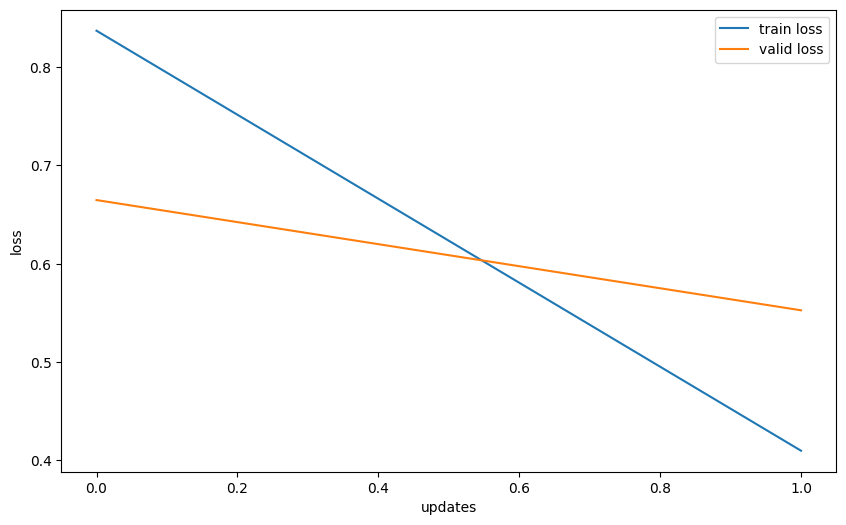

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

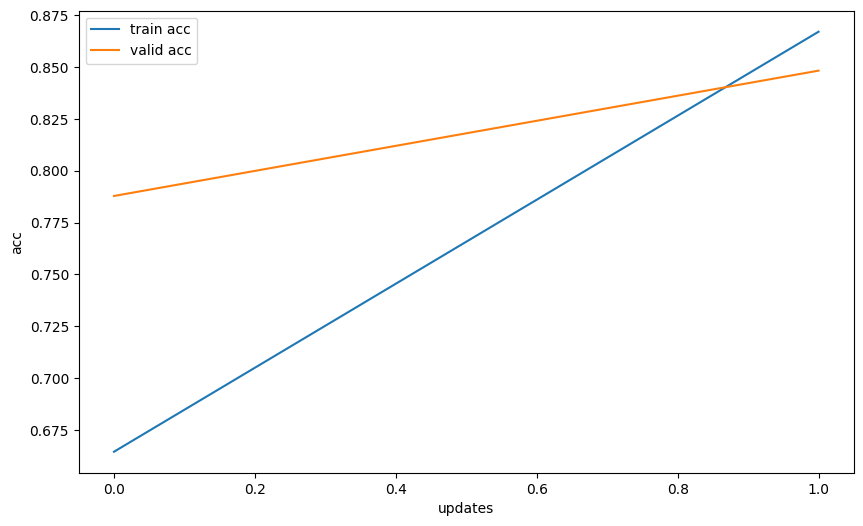

In [48]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(val_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [49]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.538 | Test Acc: 84.07%


## 8. Test on some random news

In [50]:
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([ 154,   27,  289, 3361,    0,    6,   16,   21,  412,   27, 2094, 1428,
         289,    6])

In [51]:
text_list = [x.item() for x in text]
text_list

[154, 27, 289, 3361, 0, 6, 16, 21, 412, 27, 2094, 1428, 289, 6]

In [52]:
[mapping[num] for num in text_list]

['Google',
 'is',
 'now',
 'falling',
 '<unk>',
 '.',
 ' ',
 'The',
 'price',
 'is',
 'really',
 'bad',
 'now',
 '.']

In [53]:
text = text.reshape(1, -1)  #because batch_size is 1

In [54]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [55]:
text.shape

torch.Size([1, 14])

In [56]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [57]:
predict(text, text_length)

tensor([2])